# crms_irf.ipynb

trying iterative random forests on random forest generated from both 
1. try irf on housekeeping gene subset of model for each cell type


based on https://github.com/Yu-Group/iterative-Random-Forest/blob/master/demo/28_iRF_demo_sklearn.ipynb

and the Iteratve Random Forest (Basu paper)





In [1]:
# basic packages
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import itertools
from collections import Counter, defaultdict
import time

# machine learning packages from sklearn
from sklearn.preprocessing import MinMaxScaler #StandardScaler 
from sklearn import preprocessing, metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, plot_roc_curve, confusion_matrix, accuracy_score
from scipy import interp

# for IRF
from functools import reduce
# Needed for the scikit-learn wrapper function
import irf
from irf import (irf_utils, utils,
                 irf_jupyter_utils)
from irf.ensemble.wrf import RandomForestClassifierWithWeights
from math import ceil

# Import our custom utilities
from imp import reload


# Import tools needed for visualization
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import pydot

In [2]:
# TF annotations
hoco_annon_file = 'annon/HOCOMOCOv11_core_annotation_HUMAN_mono.tsv'
hoco_annon = pd.read_table(hoco_annon_file,header=0)
hoco_annon[['motif_abbr','motif_info']]=hoco_annon['Model'].str.split("_",expand=True)
hoco_motif_to_tf = pd.Series(hoco_annon['Transcription factor'].values, index=hoco_annon.motif_abbr.values).to_dict()
tfs = list(hoco_annon['Transcription factor'])


# RNA
THRES=1
rna_tpm_file = 'rnaseq/tissue_tpm_sym.csv'
rna_df = pd.read_csv(rna_tpm_file, index_col=0,header=0)
rna_df.index = [x.upper() for x in rna_df.index.values]
all_genes = rna_df.index
tissue_diffloop_to_rna = {
    'Air':'Airway', 'Astro':'Astrocyte', 'Blad':'Bladder', 'Colon':'Colon', 'Eso':'Esophageal', 
    'GDSD0':'GDSD0', 'GDSD3':'GDSD3', 'GDSD6':'GDSD6', 
    'GM12878':'GM12878', 'HMEC':'HMEC', 'MC':'Melanocytes', 'Ova':'Ovarian',
    'Panc':'Pancreas', 'Pros':'Prostate', 'Renal':'Renal', 'Thy':'Thyroid', 'Uter':'Uterine'
}

def get_exp(rna_df, sym, tissue,verbose=True):
    try:
        return rna_df.loc[sym,tissue]
    except KeyError:
        if verbose:
            print(sym, 'not found')
        return 0
   
# loop and anchor and crms
loop_files = sorted(glob.glob('diffloop_data/bedpe_files_csvs_rna/*merged.loops.csv'))
anchor_files = sorted(glob.glob('diffloop_data/bedpe_files_csvs_rna/*merged.anchors.csv'))
crm_files = sorted(glob.glob('networks/diffgene/all_no_thres/*_crm_tissue.csv'))


tissues = []
for crm in crm_files:
    tissues.append(os.path.basename(crm).split('_')[1])
tissue_dict = dict(zip(tissues,range(len(tissues))))

# print(loop_files)
# print(anchor_files)

# 0. Data Wrangling
- import
- preprocess


In [10]:
# import
data_all = pd.read_csv('networks/representations_no_tfs/data_all.csv',index_col=0,header=0)
labels_all = np.array(pd.read_csv('networks/representations_no_tfs/labels_all.csv',index_col=0,header=None))
genes_all = np.array(pd.read_csv('networks/representations_no_tfs/genes_all.csv',index_col=0,header=None))


data_all.shape, labels_all.shape,genes_all.shape


((291006, 824), (291006, 1), (291006, 1))

In [11]:
# # labels for problem 1: `labels_all_bin`
# labels_all_bin = np.array([1 if x > THRES else 0 for x in labels_all])

In [12]:
# labels for problem 2: `tissue_labels`
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)


tissue_to_num_dict = dict(zip(tissue_dict.keys(), range(len(tissue_dict.keys()))))
tissue_df = data_all[tissue_dict.keys()].reset_index().melt('index')
tissue_df.columns = ['index','tissue','value']
tissue_df = tissue_df[tissue_df.value==1].reset_index(drop=True)
tissue_df['tissue_num'] = tissue_df.tissue.map(tissue_to_num_dict)

tissue_labels = np.array(tissue_df.tissue)
tissue_num_labels = np.array(tissue_df.tissue_num)

print(Counter(tissue_labels))

Counter({'Air': 17118, 'Astro': 17118, 'Blad': 17118, 'Colon': 17118, 'Eso': 17118, 'GDSD0': 17118, 'GDSD3': 17118, 'GDSD6': 17118, 'GM12878': 17118, 'HMEC': 17118, 'MC': 17118, 'Ova': 17118, 'Panc': 17118, 'Pros': 17118, 'Renal': 17118, 'Thy': 17118, 'Uter': 17118})


In [14]:
# pd.DataFrame([tissue_diffloop_to_rna[x] for x in tissue_labels]).to_csv(os.path.join(save_dir, 'tissues_all.csv'), header=None)

In [15]:
# labels_all = np.array(pd.read_csv('networks/representations_irf_cca/tissues_all.csv',index_col=0,header=None))
# tissue_bool_idx = np.where(labels_all=='Airway')[0]
# len(tissue_bool_idx) #17118

In [16]:
# set up data collection, remove the tissues and uninformative columns

data_all_no_tissue = data_all
    
if '_loop' in data_all_no_tissue.columns:
    data_all_no_tissue.drop('_loop',axis=1,inplace=True)

for tissue in tissue_dict.keys():
    if tissue in data_all_no_tissue.columns:
        data_all_no_tissue.drop(tissue,axis=1,inplace=True)

In [17]:
# data for problem 1: `data_all_norm_`
data_all_1 = data_all_no_tissue#.copy()

# # make sure expression is removed
# if 'log_exp' in data_all_1.columns:
#     data_all_1.drop('log_exp',axis=1,inplace=True)
    
if 'num_atac_regions' in data_all_1.columns:
    data_all_1.drop('num_atac_regions',axis=1,inplace=True)

if 'num_snp' in data_all_1.columns:
    data_all_1.drop('num_snp',axis=1,inplace=True)

    
if 'num_loop_counts' in data_all_1.columns:
    data_all_1.drop('num_loop_counts',axis=1,inplace=True)

if 'num_loops' in data_all_1.columns:
    data_all_1.drop('num_loops',axis=1,inplace=True)

    
# remove zero variance columns and scale rest
selector = VarianceThreshold()
data_all_varfilt_1 = selector.fit_transform(data_all_1)
data_all_varfilt_cols_1 = data_all_1.columns[selector.get_support()]
print(data_all_1.shape, data_all_varfilt_1.shape, len(data_all_varfilt_cols_1))
scaler = MinMaxScaler()
data_all_norm_1 = scaler.fit_transform(data_all_varfilt_1)
print(data_all_varfilt_1.shape, data_all_norm_1.shape)
    

(291006, 802) (291006, 648) 648
(291006, 648) (291006, 648)


In [18]:
# # data for problem 2: `data_all_norm_2`
# data_all_2 = data_all_no_tissue.copy()

# # keep gene expression value and the id of the gene itself
# data_all_2['log_exp'] = labels_all
# data_all_2['gene_num'] = genes_num_all

# selector = VarianceThreshold()
# data_all_varfilt_2 = selector.fit_transform(data_all_2)
# data_all_varfilt_cols_2 = data_all_2.columns[selector.get_support()]
# print(data_all_2.shape, data_all_varfilt_2.shape, len(data_all_varfilt_cols_2))
# scaler = MinMaxScaler()
# data_all_norm_2 = scaler.fit_transform(data_all_varfilt_2)
# print(data_all_varfilt_2.shape, data_all_norm_2.shape)

In [19]:
save_dir = 'networks/representations_irf_cell_type'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [20]:
# pd.DataFrame(data_all_norm_1, columns=data_all_varfilt_cols_1).to_csv(os.path.join(save_dir, 'data.csv'))


# A. Problem 1: try irf on housekeeping gene subset of model for each cell type

try GDSD3

## A.1 split data and run RF

based on previous analysis, ideally running irf on 20% of the data will save time and energy

so we will only be trying housekeeping genes (n=398)

In [21]:
all_expr_genes_tpm1 = list(pd.read_csv('rnaseq/all_expr_genes_tpm1.csv')['x'])
print(len(all_expr_genes_tpm1))

gene_in_highexpr_bool = np.isin(genes_all, all_expr_genes_tpm1)
gene_in_highexpr_bool_idx = np.where(gene_in_highexpr_bool)[0]
len(gene_in_highexpr_bool_idx)

7091


107780

In [22]:
# get housekeeping genes
housekeeping_df = pd.read_table(os.path.join('annon', 'HSIAO_HOUSEKEEPING_GENES.txt'),skiprows=2, header=None)
housekeeping_df.columns = ['genes']
housekeeping_genes_list = list(housekeeping_df.genes)
len(housekeeping_genes_list)

# tss_df_tissue = pd.read_csv('atac_footprinting/tss_footprints/GDSD3_tss_hoco_tf_exp_1000.csv', index_col=0)



398


for reference use values (rna spelling)
tissue_diffloop_to_rna = {
    'Air':'Airway', 'Astro':'Astrocyte', 'Blad':'Bladder', 'Colon':'Colon', 'Eso':'Esophageal', 
    'GDSD0':'GDSD0', 'GDSD3':'GDSD3', 'GDSD6':'GDSD6', 
    'GM12878':'GM12878', 'HMEC':'HMEC', 'MC':'Melanocytes', 'Ova':'Ovarian',
    'Panc':'Pancreas', 'Pros':'Prostate', 'Renal':'Renal', 'Thy':'Thyroid', 'Uter':'Uterine'
}


In [120]:
rf_tissue = 'GM12878'
gene_tissue = 'GM12878'

In [121]:
cell_type_genes_tpm1 = pd.read_csv('rnaseq/unique_gene_lists/'+gene_tissue+'_genes.txt',header=None).loc[:,0]
print(len(cell_type_genes_tpm1))

cell_type_genes_tpm1_bool = np.isin(genes_all, cell_type_genes_tpm1)
cell_type_genes_tpm1_bool_idx = np.where(cell_type_genes_tpm1_bool)[0]
len(cell_type_genes_tpm1_bool_idx)



506


4607

In [122]:
# takes a long time
gene_in_hk_bool = np.isin(genes_all, housekeeping_genes_list)
gene_in_hk_bool_idx = np.where(gene_in_hk_bool)[0]
len(gene_in_hk_bool_idx)


6205

In [123]:
# loop through all data
tissue_bool_labels = (tissue_labels==rf_tissue)
tissue_bool_idx = np.where(tissue_bool_labels)[0]
tissue_bool_idx.shape


(17118,)

In [124]:
select_idx = cell_type_genes_tpm1_bool_idx#list(set(tissue_bool_idx).intersection(gene_in_hk_bool_idx))
print(len(select_idx), data_all_norm_1.shape[0], len(select_idx)/data_all_norm_1.shape[0])


4607 291006 0.015831288701951163


In [125]:
#### TESTING #####
perc = .05
num_sample = int(data_all_norm_1.shape[0]*perc)
random_idx = np.random.choice(range(data_all_norm_1.shape[0]),num_sample,replace=False)
print(perc, random_idx.shape[0], data_all_norm_1.shape[0])
# num_sample = int(select_idx.shape[0]*perc)
# random_idx = np.random.choice(select_idx,num_sample,replace=False)
# print(perc, random_idx.shape[0], select_idx.shape[0])





0.05 14550 291006


In [126]:
Counter(tissue_bool_labels[select_idx])

Counter({False: 4336, True: 271})

In [127]:
# Split the data into training and testing sets
# train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm_1, labels_all_bin,
#                                                                             test_size = 0.25, random_state = 42)

# train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm_1[random_idx,:], 
#                                                                             tissue_bool_labels[random_idx], 
#                                                                             test_size = 0.25, random_state = 42)

train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm_1[select_idx,:], 
                                                                            tissue_bool_labels[select_idx], 
                                                                            test_size = 0.25, random_state = 42)



print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (3455, 648)
Training Labels Shape: (3455,)
Testing Features Shape: (1152, 648)
Testing Labels Shape: (1152,)


In [128]:
%%time
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100,#50, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
# Fit on training data
model.fit(train_features, train_labels)
# Actual class predictions
rf_predictions = model.predict(test_features)


CPU times: user 3.08 s, sys: 116 ms, total: 3.2 s
Wall time: 580 ms


In [129]:
model.predict_proba(test_features).shape

(1152, 2)

0.9765625
[[1082    0]
 [  27   43]]
0.9036836546078691


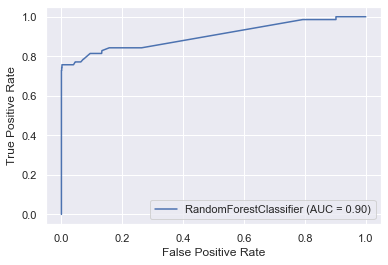

In [130]:
# evaluation
acc = accuracy_score(test_labels, rf_predictions)
print(acc)
# Probabilities for each class
rf_probs = model.predict_proba(test_features)[:, 1]
# Calculate roc auc
print(confusion_matrix(test_labels, rf_predictions))
roc_value = roc_auc_score(test_labels, rf_probs)
print(roc_value)
plot_roc_curve(model, test_features, test_labels) 
# Extract feature importances

In [131]:
for file in glob.glob('rnaseq/unique_gene_lists/*txt'):
    print(os.path.basename(file).split('_')[-2])

Colon
GDSD0
Airway
GDSD6
Pancreas
Uterine
Ovarian
Bladder
Melanocytes
HMEC
Prostate
GM12878
Renal
GDSD3
Esophageal
Astrocyte
Thyroid


Log

when looking at 5% of highly expressed gene crm data, get about auc .8, , if use all data get auc .87, this is predicting GDSD3
0.9465875370919882
[[1267    0]
 [  72    9]]
0.8061475050425327

(5% of data)

pretty good


for predicting GDSD6 with GDSD6 specific genes, get auc of .85 (num genes is 256)

## A.2: Get all Random Forest and Decision Tree Data
Extract in a single dictionary the random forest data and for all of it's decision trees
This is as required for RIT purposes

In [132]:
%%time
all_rf_tree_data = utils.get_rf_tree_data(
    rf=model, X_train=train_features, X_test=test_features, y_test=test_labels)

# all_rf_tree_data = get_rf_tree_data(
#     rf=model, X_train=train_features, X_test=test_features, y_test=test_labels)

CPU times: user 35.7 s, sys: 2.54 s, total: 38.3 s
Wall time: 38.5 s


## A.3: Get the RIT data and produce RITs

RIT = random interaction tree

In [133]:
np.random.seed(12)
all_rit_tree_data = irf_utils.get_rit_tree_data(
    all_rf_tree_data=all_rf_tree_data,
    bin_class_type=1,
    M=100,
    max_depth=2,
    noisy_split=False,
    num_splits=2)
# Perform Manual CHECKS on the irf_utils
# These should be converted to unit tests and checked with nosetests -v test_irf_utils.py

## A.4: Plot and Evaluate Data
### List Ranked Feature Importances

In [134]:
# Print the feature ranking (from irf)
# print("Feature ranking:")

feature_importances_rank_idx = all_rf_tree_data['feature_importances_rank_idx']
feature_importances = all_rf_tree_data['feature_importances']

pd.DataFrame({'rank': range(1,train_features.shape[1]+1),
             'feature': data_all_varfilt_cols_1[feature_importances_rank_idx],
             'score':feature_importances[feature_importances_rank_idx]})
# for f in range(train_features.shape[1]):
#     print("%d. feature %s (%f)" % (f + 1
#                                    , data_all_varfilt_cols_1[feature_importances_rank_idx][f]
#                                    , feature_importances[feature_importances_rank_idx[f]]))

,rank,feature,score
0,1,SPIB_loop,0.073172
1,2,EGR2_loop,0.061718
2,3,IRF4_loop,0.044318
3,4,TBX21_loop,0.032977
4,5,SP4_loop,0.029375
...,...,...,...
643,644,HIC1_anc,0.000000
644,645,SOX5_anc,0.000000
645,646,GRHL2_anc,0.000000
646,647,GFI1_anc,0.000000


In [135]:
# compare to what sklearn directly outputs
fi = pd.DataFrame({'feature': list(data_all_varfilt_cols_1),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head(10)

,feature,importance
443,SPIB_loop,0.073172
77,EGR2_loop,0.061718
197,IRF4_loop,0.044318
467,TBX21_loop,0.032977
441,SP4_loop,0.029375
73,EBF1_loop,0.023383
257,MEF2C_loop,0.023310
513,TP73_loop,0.021849
189,IKZF1_loop,0.016745
229,LEF1_loop,0.014944


### Plot Ranked Feature Importances

In [136]:
# # Plot the feature importances of the forest
# feature_importances_std = all_rf_tree_data['feature_importances_std']

# plt.title("Feature importances")
# plt.bar(range(train_features.shape[1])
#         , feature_importances[feature_importances_rank_idx]
#         , color="r"
#         , yerr = feature_importances_std[feature_importances_rank_idx], align="center")
# plt.xticks(range(train_features.shape[1]), feature_importances_rank_idx)
# plt.xlim([-1, train_features.shape[1]])
# plt.show()

## A.5: Run the iRF function!


We will run the iRF with the following parameters
Data:
- CRM data
- random state (for reproducibility): 2018
Weighted RFs
- K: 5 iterations
- number of trees: 20
Bootstrap RFs
- proportion of bootstrap samples: 20%
- B: 30 bootstrap samples
- number of trees (bootstrap RFs): 5 iterations
RITs (on the bootstrap RFs)
- M: 20 RITs per forest
- filter label type: 1-class only
- Max Depth: 5
- Noisy Split: False
- Number of splits at Node: 2 splits


#### Running the iRF is easy - single function call
All of the bootstrap, RIT complexity is covered through the key parameters passed through in the main algorithm (as listed above)
This function call returns the following data:
m score

This is a lot of data returned! Will be useful when they build the interface later

In [137]:
%%time
all_rf_weights, all_K_iter_rf_data, \
all_rf_bootstrap_output, all_rit_bootstrap_output, \
stability_score = irf_utils.run_iRF(X_train=train_features,
                                    X_test=test_features,
                                    y_train=train_labels,
                                    y_test=test_labels,
                                    K=10,
                                    rf=RandomForestClassifierWithWeights(n_estimators=100),
                                    B=30,
                                    random_state_classifier=2018,
                                    propn_n_samples=.2,
                                    bin_class_type=1,
                                    M=25,
                                    max_depth=5,
                                    noisy_split=False,
                                    num_splits=2,
                                    n_estimators_bootstrap=5)

CPU times: user 5min, sys: 16.7 s, total: 5min 17s
Wall time: 5min 17s


THIS IS WHAT WE CARE ABOUT `stability_score`

In [138]:
data_all_varfilt_cols_1

Index(['AHR_anc', 'AHR_loop', 'ALX1_anc', 'ALX1_loop', 'ARID5B_anc',
       'ARID5B_loop', 'ARNTL_anc', 'ARNTL_loop', 'ARNT_anc', 'ARNT_loop',
       ...
       'ZNF76_anc', 'ZNF76_loop', 'ZNF770_anc', 'ZNF770_loop', 'ZNF816_anc',
       'ZNF816_loop', 'ZNF85_anc', 'ZNF85_loop', 'ZSCAN31_anc',
       'ZSCAN31_loop'],
      dtype='object', length=648)

In [139]:
stability_score_names = {}
for feat_idx, score in sorted(stability_score.items(),key=lambda x:x[1],reverse=True):
    feat_names_arr = [data_all_varfilt_cols_1[int(x)] for x in feat_idx.split('_')]
    feat_names = '::'.join(feat_names_arr)
    stability_score_names[feat_names] = score
stability_df = pd.Series(stability_score_names)
save_file = os.path.join(save_dir, 'test_'+rf_tissue+'_' + gene_tissue + '_stability_score.csv')
stability_df.to_csv(save_file)
print(save_file)
stability_df

networks/representations_irf_cell_type/test_GM12878_GM12878_stability_score.csv


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


SPIB_loop                                              0.866667
EGR2_loop                                              0.800000
EGR2_loop::SPIB_loop                                   0.666667
EGR2_loop::PATZ1_loop                                  0.566667
EGR2_loop::PATZ1_loop::SPIB_loop                       0.400000
                                                         ...   
PATZ1_loop::RUNX3_loop::SPIB_loop                      0.033333
IRF4_loop::KLF5_loop::PATZ1_loop::SP4_anc::SP4_loop    0.033333
FLI1_loop::IRF4_loop::LYL1_loop::SP4_loop              0.033333
IRF4_loop::PATZ1_loop::SP4_anc::SP4_loop               0.033333
EGR2_loop::IRF7_loop::OSR2_anc::SPIB_loop              0.033333
Length: 259, dtype: float64

In [140]:
# freq_feat = pd.DataFrame(train_features, columns=data_all_varfilt_cols_1).sum(axis=0).sort_values(ascending=False)
# pd.DataFrame(freq_feat)[:20]

In [141]:
pd.DataFrame(stability_df)[:20]

,0
SPIB_loop,0.866667
EGR2_loop,0.800000
EGR2_loop::SPIB_loop,0.666667
EGR2_loop::PATZ1_loop,0.566667
EGR2_loop::PATZ1_loop::SPIB_loop,0.400000
IRF4_loop,0.300000
EGR2_loop::IRF4_loop::SPIB_loop,0.300000
EGR2_loop::ZNF467_loop,0.300000
IRF4_loop::SPIB_loop,0.300000
EGR2_loop::SPIB_loop::TP73_loop,0.200000


### Examine the stability scores

In [ ]:
irf_jupyter_utils._get_histogram(stability_score, sort = True)

### Examine feature importances
In particular, let us see how they change over the K iterations of random forest

In [176]:
# for k in range(1, 6): 
    
#     iteration = "rf_iter{}".format(k)
    
#     feature_importances_std = all_K_iter_rf_data[iteration]['feature_importances_std']
#     feature_importances_rank_idx = all_K_iter_rf_data[iteration]['feature_importances_rank_idx']
#     feature_importances = all_K_iter_rf_data[iteration]['feature_importances']

#     plt.figure(figsize=(8, 6))
#     title = "Feature importances; iteration = {}".format(k)
#     plt.title(title)
#     plt.bar(range(train_features.shape[1])
#             , feature_importances[feature_importances_rank_idx]
#             , color="r"
#             , yerr = feature_importances_std[feature_importances_rank_idx], align="center")
#     plt.xticks(range(train_features.shape[1]), feature_importances_rank_idx, rotation='vertical')
#     plt.xlim([-1, train_features.shape[1]])
#     plt.show()

## A.6 Explore iRF Data Further
We can look at the decision paths of the Kth RF
Let's look at the final iteration RF - the key validation metrics

In [91]:
irf_jupyter_utils.pretty_print_dict(all_K_iter_rf_data['rf_iter5']['rf_validation_metrics'])
# {   'accuracy_score': 0.9649122807017544,
#     'confusion_matrix': array([[12,  2],
#        [ 0, 43]]),
#     'f1_score': 0.9772727272727273,
#     'hamming_loss': 0.03508771929824561,
#     'log_loss': 1.2119149470996806,
#     'precision_score': 0.9555555555555556,
#     'recall_score': 1.0,
#     'zero_one_loss': 0.03508771929824561}

{   'accuracy_score': 0.7256,
    'confusion_matrix': array([[ 777,  370],
       [ 316, 1037]]),
    'f1_score': 0.7514492753623188,
    'hamming_loss': 0.2744,
    'log_loss': 9.477558583183162,
    'precision_score': 0.7370291400142146,
    'recall_score': 0.7664449371766445,
    'zero_one_loss': 0.2744}


Now plot the trees individually

In [92]:
#irf_jupyter_utils.draw_tree(decision_tree = all_K_iter_rf_data['rf_iter5']['rf_obj'].estimators_[0])

We can get this data quite easily in a convenient format

In [ ]:
# irf_jupyter_utils.pretty_print_dict(
#     all_K_iter_rf_data['rf_iter5']['dtree0']['all_leaf_paths_features'])

Notes comparing above combination against decision paths

In fact - we can go further and plot some interesting data from the Decision Trees. This can help us understand variable interactions better

In [ ]:
irf_jupyter_utils.pretty_print_dict(
    all_K_iter_rf_data['rf_iter5']['dtree0']['all_leaf_node_values'])

We can also look at the frequency that a feature appears along a decision path

In [ ]:
irf_jupyter_utils._hist_features(all_K_iter_rf_data['rf_iter5'], n_estimators = 20, \
                         title = 'Frequency of features along decision paths : iteration = 5')

### Run some Sanity Checks
Run iRF for just 1 iteration - should be the uniform sampling version
This is just a sanity check: the feature importances from iRF after 1 iteration should match the feature importance from running a standard RF
    

In [ ]:
all_K_iter_rf_data.keys()
print(all_K_iter_rf_data['rf_iter1']['feature_importances'])

Compare to the original single fitted random forest

In [ ]:
# rf = RandomForestClassifierWithWeights(n_estimators=20, random_state=2018)
# rf.fit(X=X_train, y=y_train)
print(model.feature_importances_)

Notes: And they match ____(well?) as expected.
